In [1]:
import os
import numpy as np

RNG = np.random.default_rng(2023)
HOME = os.getenv("HOME")

In [2]:
from dataloaders import LineReader

reader = LineReader(
    nlines=10000,
    fparams=f"{HOME}/Datasets/cell_migration/parameters.txt",
    fseries=[
        f"{HOME}/Datasets/cell_migration/dac.txt",
        f"{HOME}/Datasets/cell_migration/msd.txt"
    ]
)

In [3]:
from bayesflow.simulation import GenerativeModel, Prior, Simulator

prior = Prior(prior_fun=reader.sample_params, param_names=["ix", "A", "B", "C", "D", "E"])
simulator = Simulator(simulator_fun=reader.simulate_series)

prior_means, prior_stds = prior.estimate_means_and_stds()
model = GenerativeModel(prior, simulator, name="basic_covid_simulator")

_ = model(10)
# print(prior_means, prior_stds)

/Users/alisamar/Desktop/cell_migration/.venv/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the basic_covid_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2, 79)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


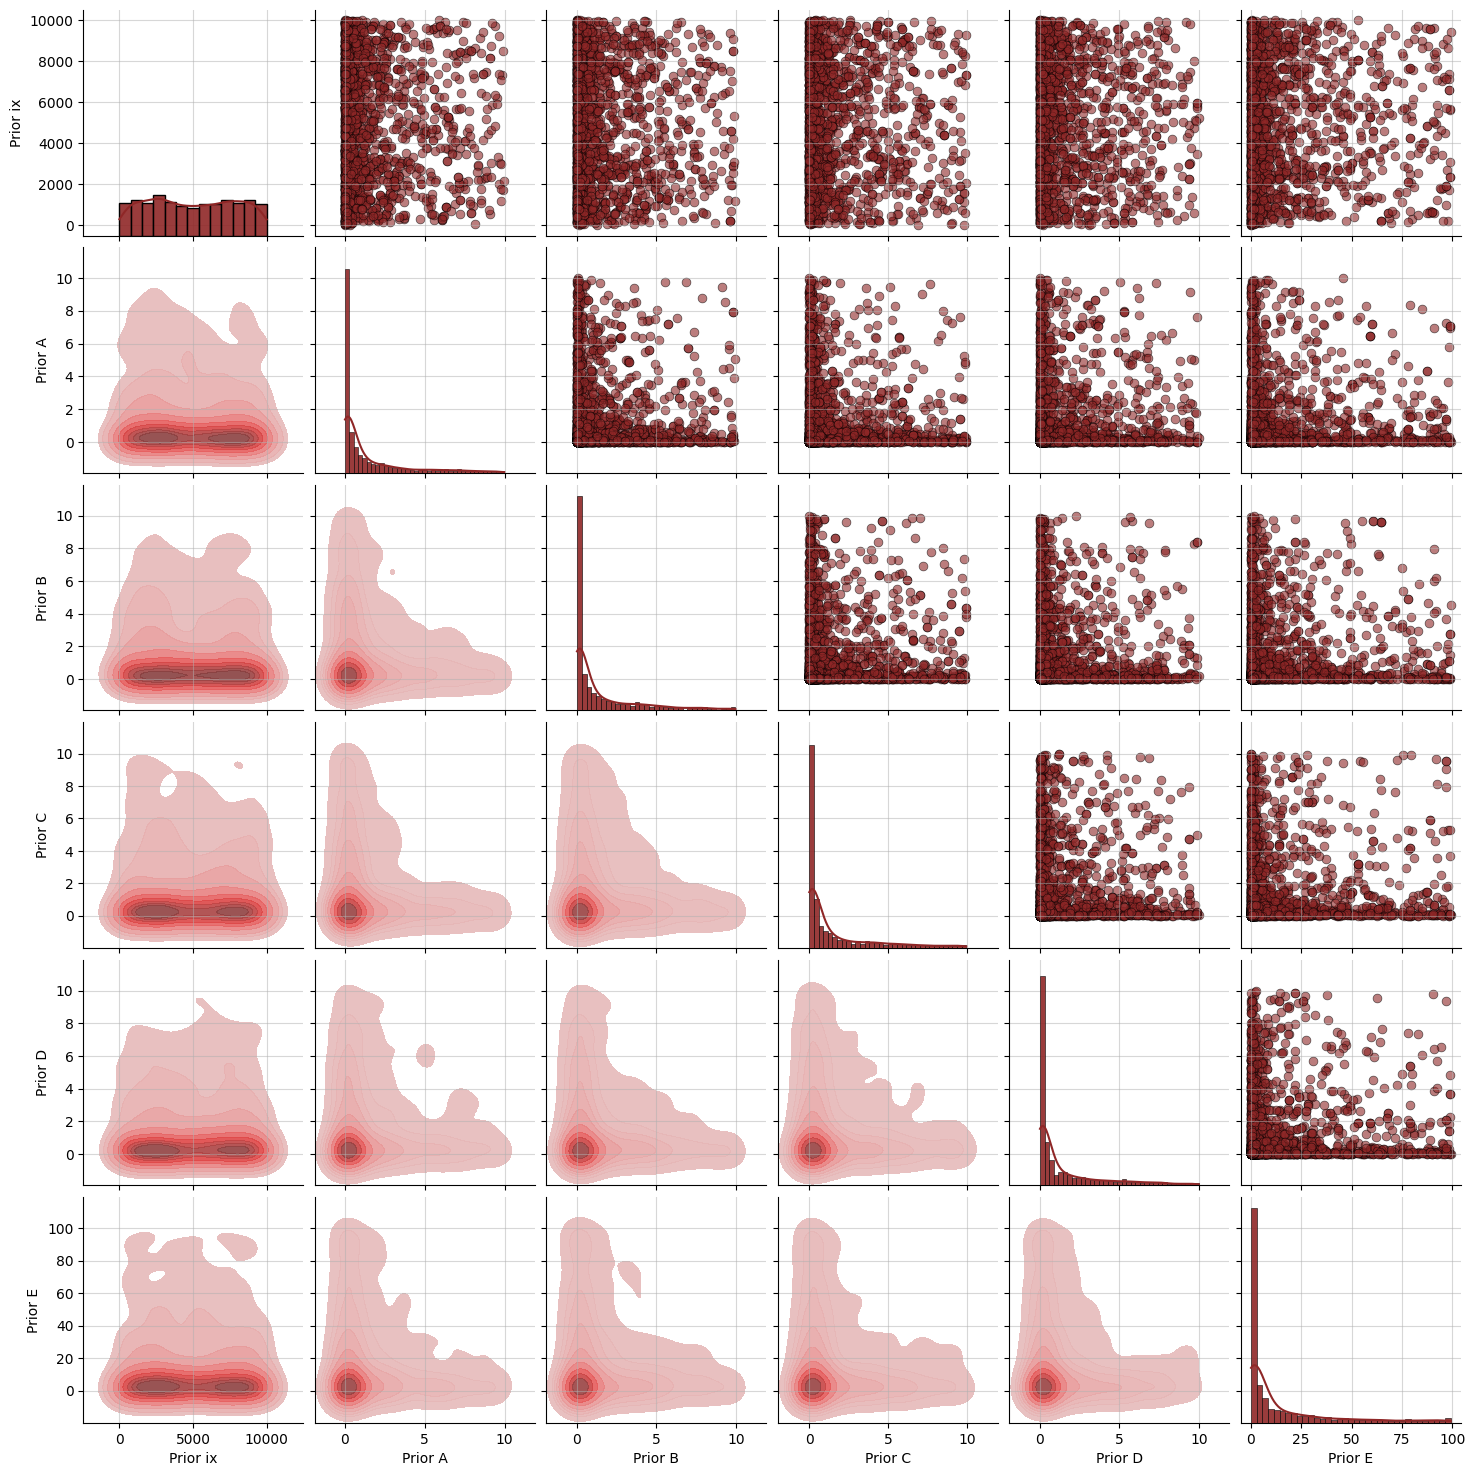

In [4]:
# As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior.plot_prior2d()

In [5]:
from bayesflow.networks import InvertibleNetwork, TimeSeriesTransformer
from bayesflow.amortizers import AmortizedPosterior

In [6]:
summary_net = TimeSeriesTransformer(input_dim=len(reader.series[0])+1)

In [7]:
inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=4)

In [8]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="covid_amortizer")

In [9]:
from bayesflow.trainers import Trainer


def configure_input(input_dict):

    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Extract prior draws and z-standardize with previously computed means
    # prior draws are the parameters we want to estimate
    params = input_dict["prior_draws"].astype(np.float32)
    params = (params - prior_means) / prior_stds

    x = input_dict['sim_data']
    batch_size, _, num_timesteps  = x.shape
    # add time encoding to the data x
    time_encoding = np.linspace(0, 1, num_timesteps)
    time_encoding_batched = np.tile(time_encoding, (batch_size, 1, 1))

    return {
        "parameters": params,
        "summary_conditions": np.concatenate((x, time_encoding_batched), axis=1).reshape(batch_size, num_timesteps, -1)
    }

trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configure_input, memory=True)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [10]:
offline_data = model(10000)
history = trainer.train_offline(offline_data, epochs=30, batch_size=32, validation_sims=200)

INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 313/313 [00:19<00:00, 15.85it/s, Epoch: 1, Batch: 313,Loss: 8.484,W.Decay: 0.128,Avg.Loss: 8.767,Avg.W.Decay: 0.178,LR: 4.99E-04]
INFO:root:Validation, Epoch: 1, Loss: 8.383
Training epoch 2: 100%|██████████| 313/313 [00:11<00:00, 28.15it/s, Epoch: 2, Batch: 313,Loss: 6.447,W.Decay: 0.108,Avg.Loss: 7.729,Avg.W.Decay: 0.112,LR: 4.95E-04]
INFO:root:Validation, Epoch: 2, Loss: 5.890
Training epoch 3: 100%|██████████| 313/313 [00:11<00:00, 27.36it/s, Epoch: 3, Batch: 313,Loss: 5.915,W.Decay: 0.109,Avg.Loss: 5.190,Avg.W.Decay: 0.109,LR: 4.88E-04]
INFO:root:Validation, Epoch: 3, Loss: 4.026
Training epoch 4: 100%|██████████| 313/313 [00:11<00:00, 26.34it/s, Epoch: 4, Batch: 313,Loss: 3.884,W.Decay: 0.109,Avg.Loss: 4.036,Avg.W.Decay: 0.109,LR: 4.78E-04]
INFO:root:Validation, Epoch: 4, Loss: 3.286
Training epoch 5: 100%|██████████| 313/313 [00:12<00:00, 25.09it/s, Epoch: 5, Batch: 313,Loss: 3.920,W.Decay: 0.

/Users/alisamar/Desktop/cell_migration/.venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


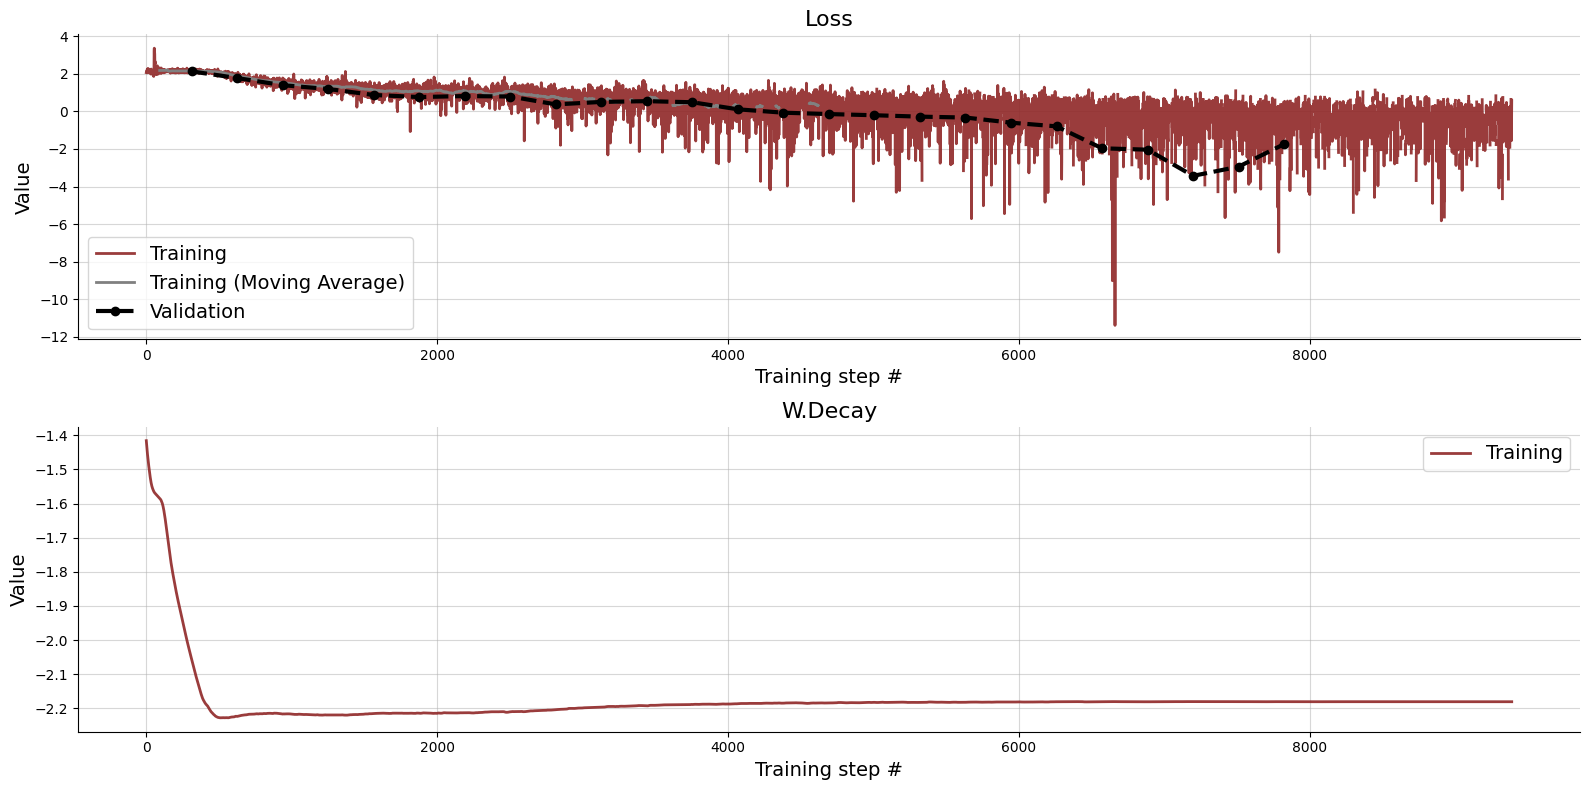

In [11]:
import bayesflow.diagnostics as diag

f = diag.plot_losses(np.log(history["train_losses"]), np.log(history["val_losses"]), moving_average=True)

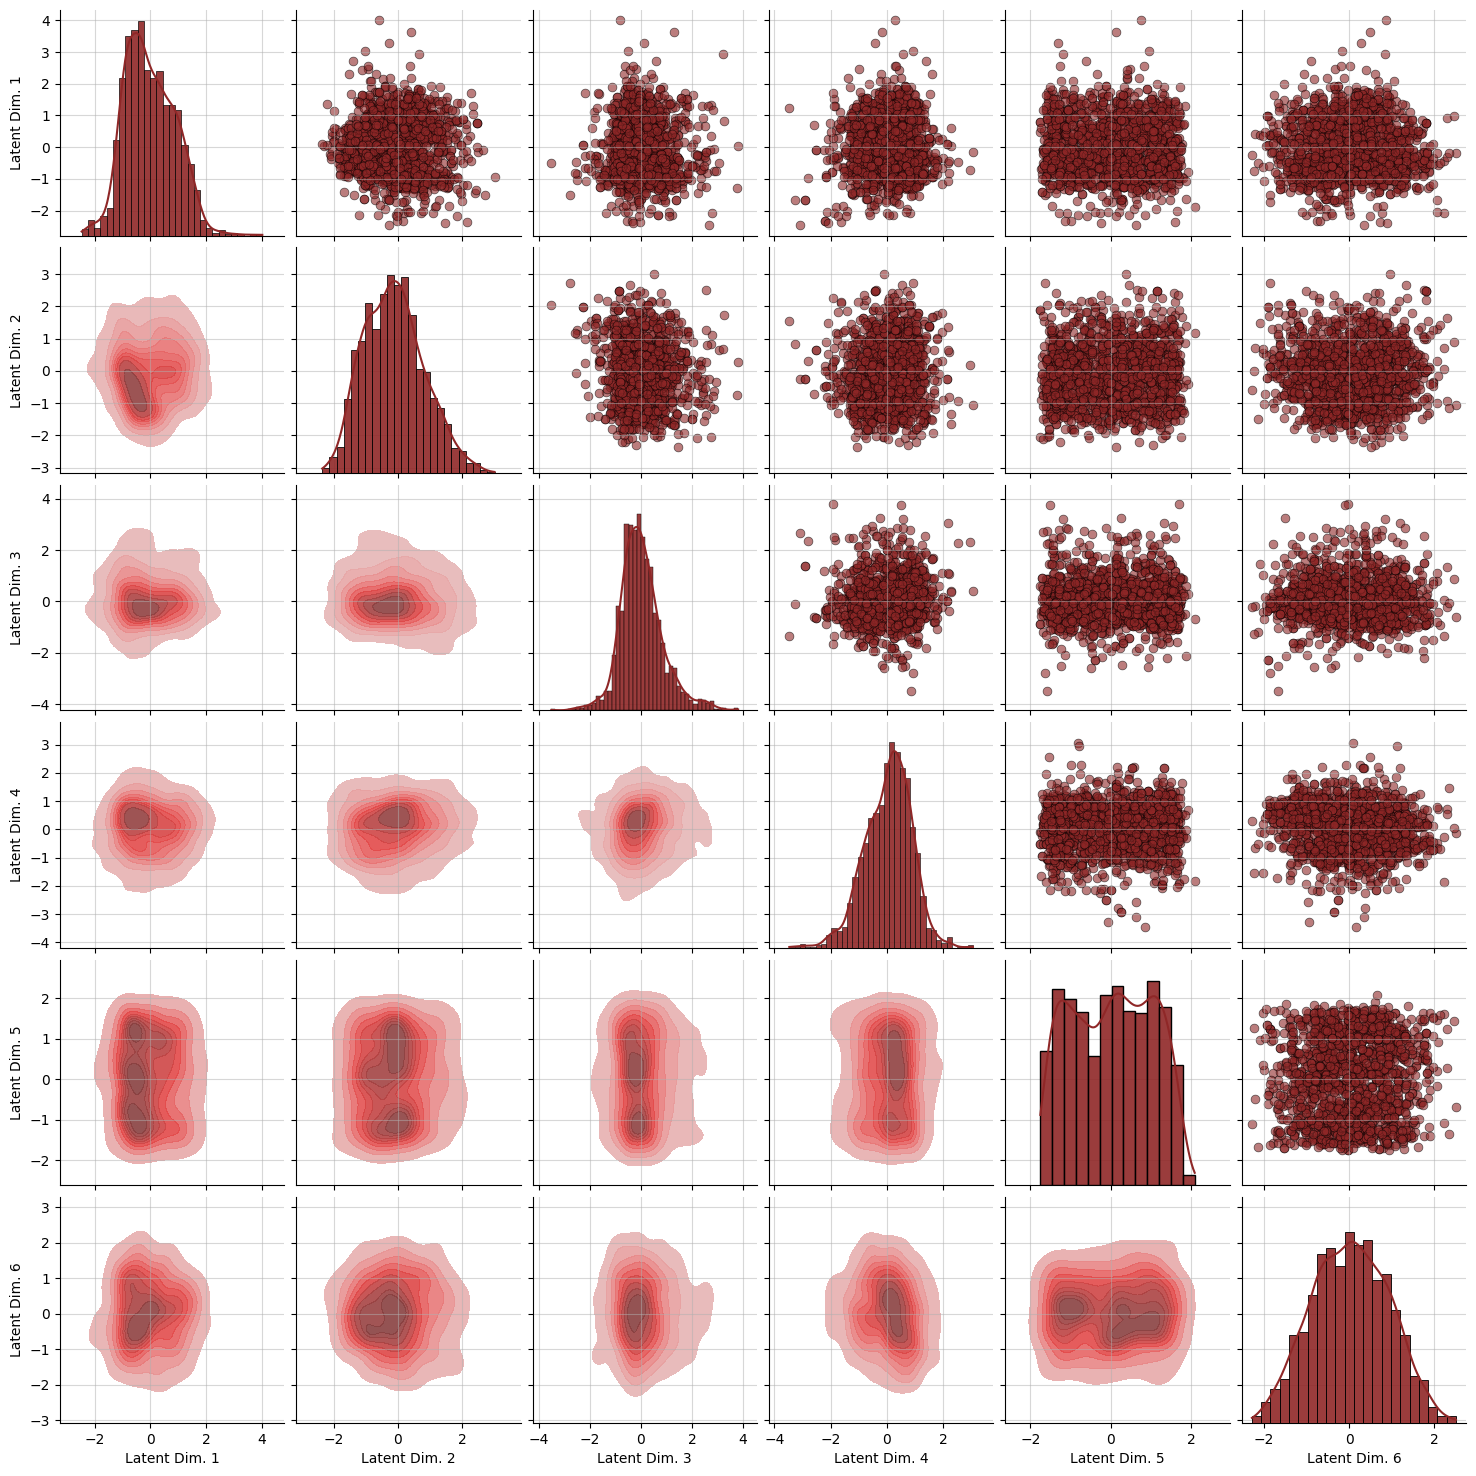

In [12]:
f = trainer.diagnose_latent2d()

In [13]:
# f = trainer.diagnose_sbc_histograms()

In [14]:
# Generate some validation data
validation_sims = trainer.configurator(model(batch_size=300))

# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)

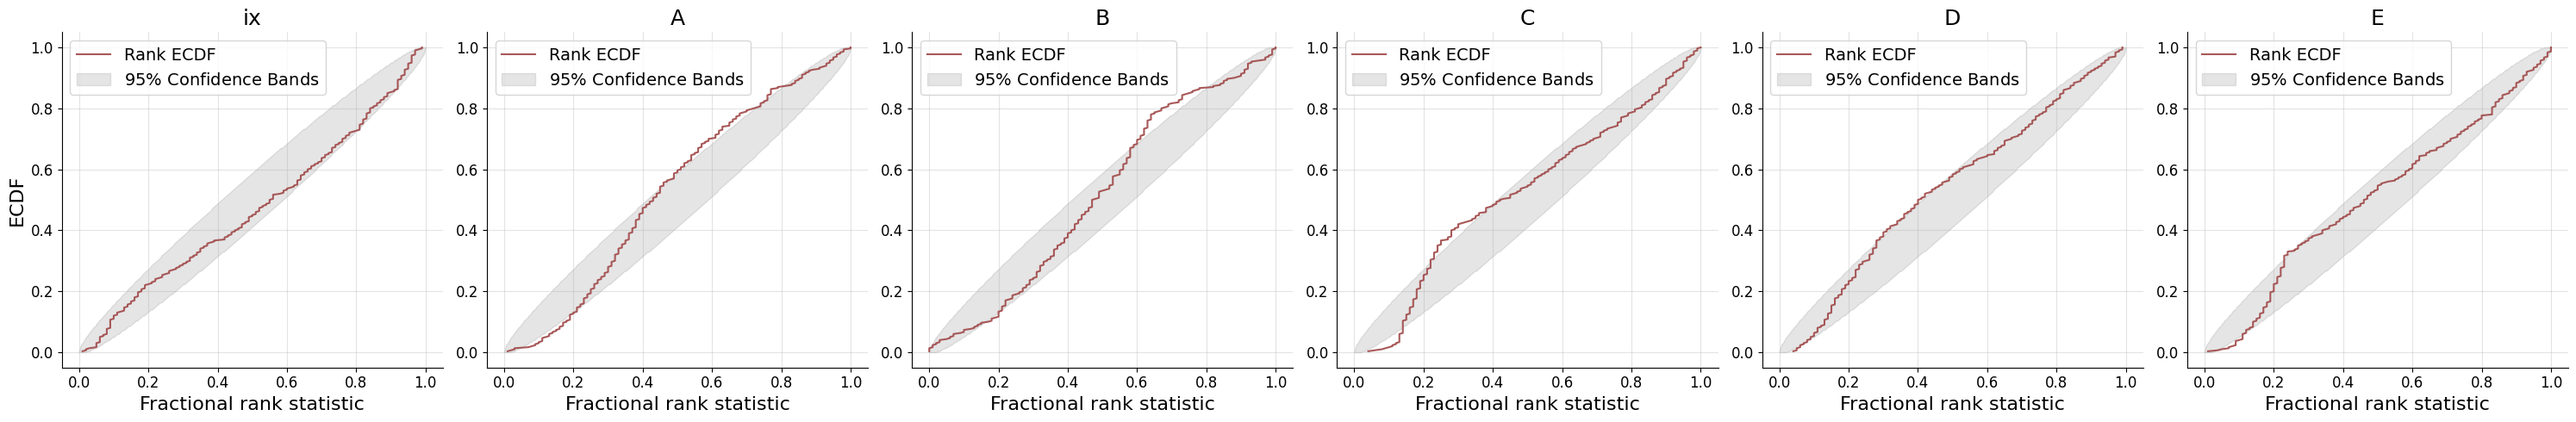

In [15]:
# Create ECDF plot
f = diag.plot_sbc_ecdf(post_samples, validation_sims["parameters"], param_names=prior.param_names)

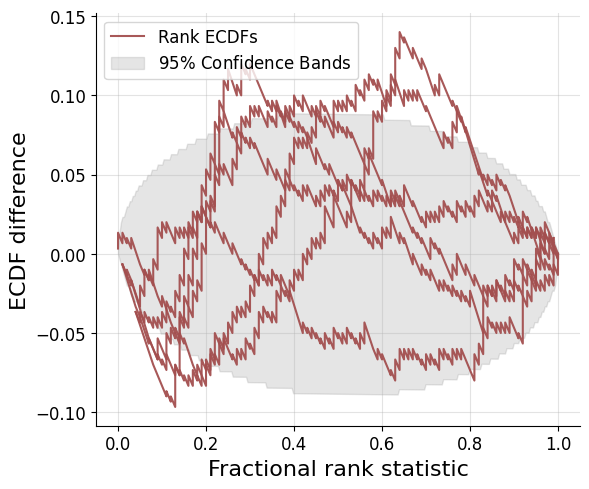

In [16]:
f = diag.plot_sbc_ecdf(
    post_samples, validation_sims["parameters"], stacked=True, difference=True, legend_fontsize=12, fig_size=(6, 5)
)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 3.                    Confidence intervals might be unreliable!


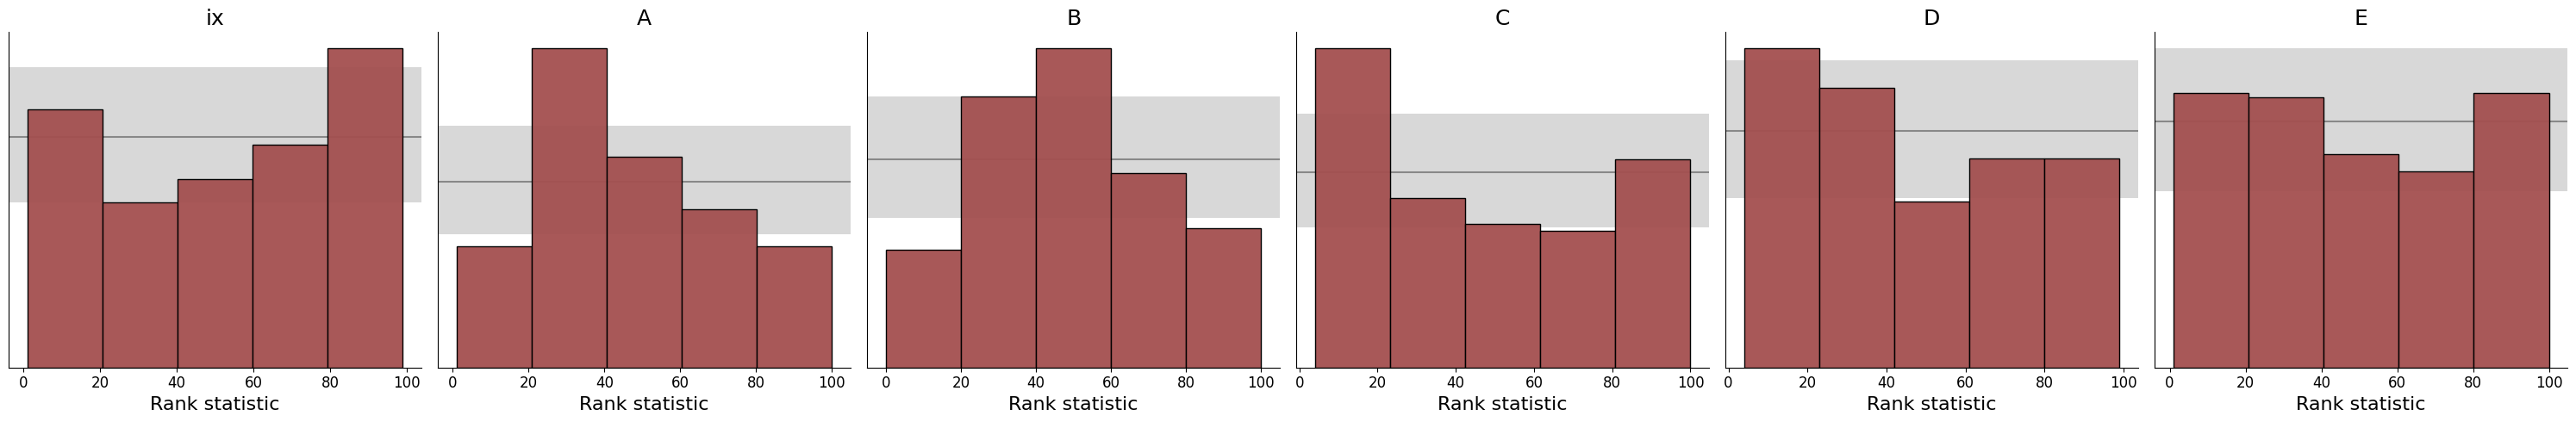

In [17]:
f = diag.plot_sbc_histograms(post_samples, validation_sims["parameters"], param_names=prior.param_names)

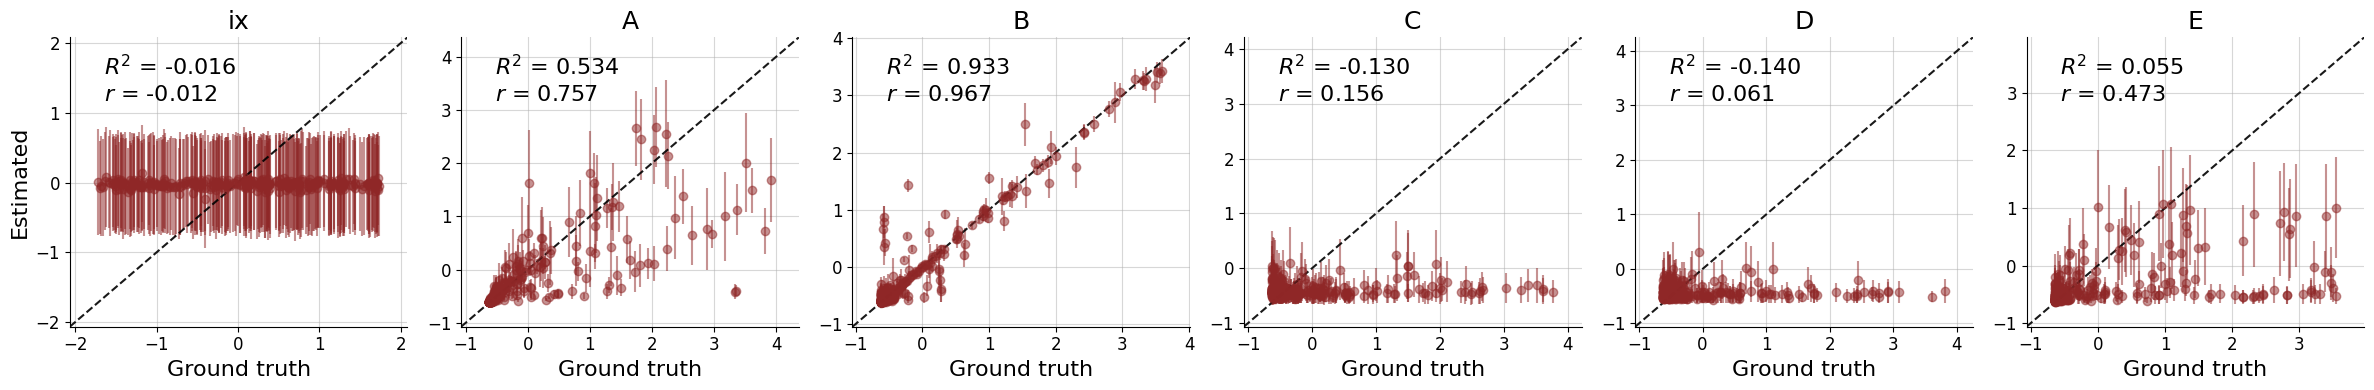

In [18]:
from diagnostics import plot_recovery

post_samples = amortizer.sample(validation_sims, n_samples=1000)
f = diag.plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)

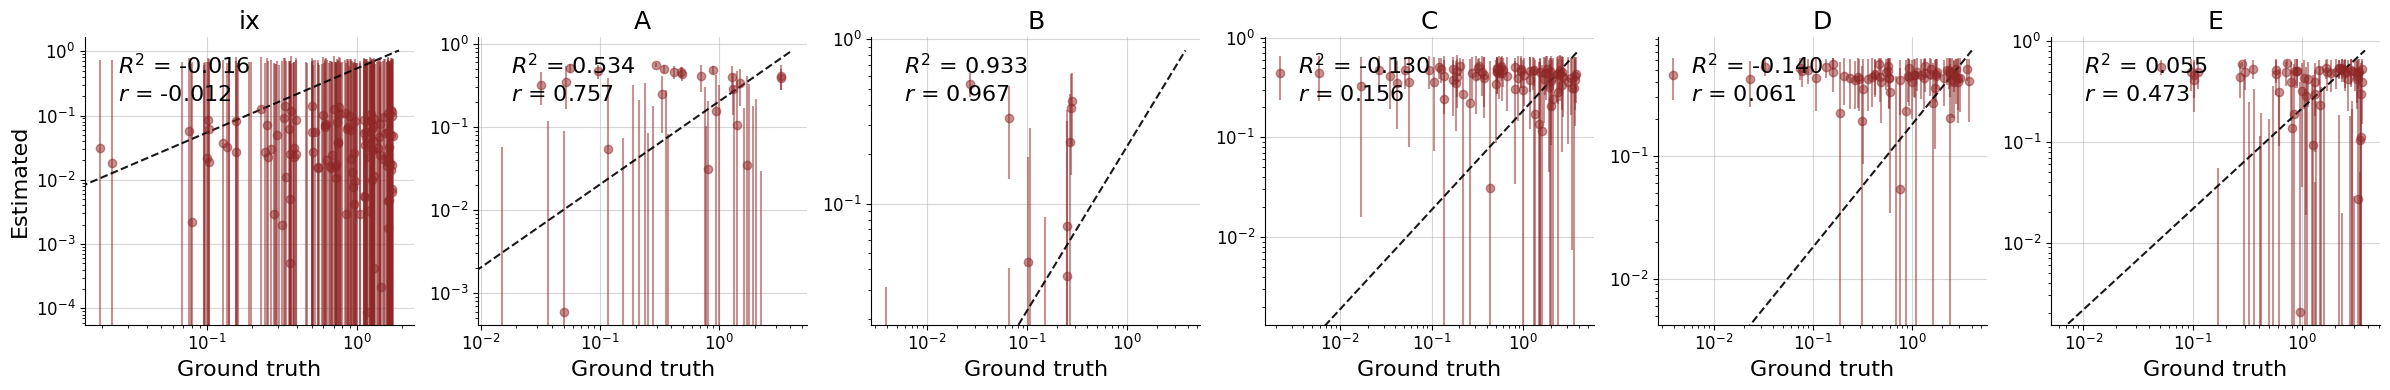

In [19]:
f = plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)